## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
!pip install swifter
!pip install TextBlob
!pip install wordcloud

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints.json
100% 83.4M/83.4M [00:00<00:00, 181MB/s]


In [4]:
# Opening JSON file 
f = open("complaints.json") # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [6]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [7]:
#Assign new column names
df.rename(columns={'_index': 'index', '_type': 'type','_id': 'id', '_score': 'score',
                   '_source.tags': 'tags', '_source.zip_code': 'zip_code','_source.complaint_id': 'complaint_id',
                   '_source.issue': 'issue','_source.date_received': 'date_received',
                   '_source.state': 'state','_source.consumer_disputed': 'consumer_disputed',
                  '_source.product': 'product','_source.company_response': 'company_response',
                  '_source.company': 'company','_source.submitted_via': 'submitted_via',
                  '_source.date_sent_to_company': 'date_sent_to_company',
                  '_source.company_public_response': 'company_public_response',
                  '_source.sub_product': 'sub_product','_source.timely': 'timely',
                  '_source.complaint_what_happened': 'complaint_what_happened', 
                  '_source.sub_issue': 'sub_issue','_source.consumer_consent_provided': 'consumer_consent_provided',}, inplace=True)

In [8]:
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [9]:
df.head(10)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [10]:
df['complaint_what_happened'].isna().sum()

0

In [11]:
(df['complaint_what_happened']=='').sum()

57241

In [12]:
#Assign nan in place of blanks in the complaints column
df = df.replace(r'^\s*$', np.NaN, regex=True)

In [13]:
df['complaint_what_happened'].isna().sum()

57241

In [14]:
(df['complaint_what_happened']=='').sum()

0

In [15]:
#pd.set_option('display.max_colwidth', None)

In [16]:
df['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [17]:
df.shape

(78313, 22)

In [18]:
#Remove all rows where complaints column is nan
df=df[~df['complaint_what_happened'].isna()]

In [19]:
df.reset_index(drop=True, inplace=True)

In [20]:
df.shape

(21072, 22)

In [21]:
df['complaint_what_happened'][df['complaint_what_happened'].str.contains('\[', regex= True, na=False)]

131      RE : Complaint Against JP Morgan Chase, XXXX H...
165      I am responding to your contact about a debt y...
395      Chase Card Address : XXXX XXXX XXXX City/ Stat...
463      onXXXX XXXX odf XXXX Chase decided to tell the...
630      We posted item [ s ] for sale on XXXX XXXX  an...
                               ...                        
20454    XXXX XXXX commits FRAUD as charging customers ...
20482    Time of Applicable Cases : Approximately, XX/X...
20726    Hi, As a loyal and long time customer of such ...
20786    I left XXXX XXXX at XXXX on Thursday XX/XX/XXX...
20868    Dear Sir, I have closed my individual chase cr...
Name: complaint_what_happened, Length: 212, dtype: object

In [22]:
df['complaint_what_happened'].head()

0    Good morning my name is XXXX XXXX and I apprec...
1    I upgraded my XXXX XXXX card in XX/XX/2018 and...
2    Chase Card was reported on XX/XX/2019. However...
3    On XX/XX/2018, while trying to book a XXXX  XX...
4    my grand son give me check for {$1600.00} i de...
Name: complaint_what_happened, dtype: object

In [23]:
df['complaint_what_happened']=df['complaint_what_happened'].str.lower()
df['complaint_what_happened'].head()

0    good morning my name is xxxx xxxx and i apprec...
1    i upgraded my xxxx xxxx card in xx/xx/2018 and...
2    chase card was reported on xx/xx/2019. however...
3    on xx/xx/2018, while trying to book a xxxx  xx...
4    my grand son give me check for {$1600.00} i de...
Name: complaint_what_happened, dtype: object

In [24]:
df['complaint_what_happened'].replace(to_replace={'xx','\d'}, value='', regex=True, inplace=True) 

In [25]:
df['complaint_what_happened'].head()

0    good morning my name is   and i appreciate it ...
1    i upgraded my   card in // and was told by the...
2    chase card was reported on //. however, fraudu...
3    on //, while trying to book a     ticket, i ca...
4    my grand son give me check for {$.} i deposit ...
Name: complaint_what_happened, dtype: object

In [26]:
df['complaint_what_happened'].replace(to_replace={'[\[].*?[\]]'}, value='', regex=True, inplace=True) 

In [27]:
df['complaint_what_happened'].iloc[630]

'we posted item  for sale on    and other websites. someone interested in buying the same. we have told that it costs {$.} and transfer the same to our account. i have shared email id of my bank account. i have told that item will be shipped after receiving the amount. they have called nextday and told that by mistake t they transferred  instead of  on // i have checked my bank account and i can see amount for {$.}. i have decided to send money back and took his email id. i have transferred the money of {$.} ( using  through    ). they told that it went to their old/closed account and they said that have called  and sent money back to my account. i have checked my bank account and i saw credit of {$.}. he asked me to transfer to his other email id since first transfer didnt work. i did the same. second time he told money didnt go through since his account locked due to low balance. he told that he called  and cancel the same. i saw second credit of {$.}. he asked me to transfer {$.} th

In [28]:
df['complaint_what_happened'].replace(to_replace={'\W+|_'}, value=' ', regex=True, inplace=True) 

In [29]:
df['complaint_what_happened'].head()

0    good morning my name is and i appreciate it if...
1    i upgraded my card in and was told by the agen...
2    chase card was reported on however fraudulent ...
3    on while trying to book a ticket i came across...
4    my grand son give me check for i deposit it in...
Name: complaint_what_happened, dtype: object

In [30]:
df['complaint_what_happened'].iloc[630]

'we posted item for sale on and other websites someone interested in buying the same we have told that it costs and transfer the same to our account i have shared email id of my bank account i have told that item will be shipped after receiving the amount they have called nextday and told that by mistake t they transferred instead of on i have checked my bank account and i can see amount for i have decided to send money back and took his email id i have transferred the money of using through they told that it went to their old closed account and they said that have called and sent money back to my account i have checked my bank account and i saw credit of he asked me to transfer to his other email id since first transfer didnt work i did the same second time he told money didnt go through since his account locked due to low balance he told that he called and cancel the same i saw second credit of he asked me to transfer this time to his sister account i tried to transfer the same from 

In [31]:
#pd.set_option('display.max_colwidth', None)

In [32]:
df['complaint_what_happened'].head()

0    good morning my name is and i appreciate it if...
1    i upgraded my card in and was told by the agen...
2    chase card was reported on however fraudulent ...
3    on while trying to book a ticket i came across...
4    my grand son give me check for i deposit it in...
Name: complaint_what_happened, dtype: object

In [33]:
#df['complaint_what_happened'].replace(to_replace={'\W+|_'}, value=' ', regex=True, inplace=True)

In [34]:
#pd.set_option('display.max_colwidth', None)

In [35]:
df['complaint_what_happened'].iloc[0]

'good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help '

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [36]:
# Write your function here to clean the text and remove all the unnecessary elements.


In [37]:
#Write your function to Lemmatize the texts
def lem_txt(data):     
        
    # Initialize empty list to store lemmas
    lem_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(data)
    for word in document:
        lem_list.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lem_list)

In [38]:
import swifter

In [39]:
# Add a column for lemmatized complaints to the dataframe
df["lemma_complaints"] =  df.swifter.apply(lambda x: lem_txt(x['complaint_what_happened']), axis=1)

# View the dataframe
df.head()

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemma_complaints
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is and i appreciate it if...,Didn't receive enough information to verify debt,Consent provided,good morning -PRON- name be and i appreciate -...
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my card in and was told by the agen...,Problem with rewards from credit card,Consent provided,i upgrade -PRON- card in and be tell by the ag...
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent ...,Information belongs to someone else,Consent provided,chase card be report on however fraudulent app...
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a ticket i came across...,Information belongs to someone else,Consent provided,on while try to book a ticket i come across an...
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it in...,Funds not handled or disbursed as instructed,Consent provided,-PRON- grand son give -PRON- check for i depos...


In [40]:
#from alive_progress import alive_bar

# View the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemma_complaints
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is and i appreciate it if...,Didn't receive enough information to verify debt,Consent provided,good morning -PRON- name be and i appreciate -...
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my card in and was told by the agen...,Problem with rewards from credit card,Consent provided,i upgrade -PRON- card in and be tell by the ag...
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent ...,Information belongs to someone else,Consent provided,chase card be report on however fraudulent app...
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a ticket i came across...,Information belongs to someone else,Consent provided,on while try to book a ticket i come across an...
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it in...,Funds not handled or disbursed as instructed,Consent provided,-PRON- grand son give -PRON- check for i depos...


In [41]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','lemma_complaints']]

In [42]:
df_clean

,complaint_what_happened,lemma_complaints
0,good morning my name is and i appreciate it if...,good morning -PRON- name be and i appreciate -...
1,i upgraded my card in and was told by the agen...,i upgrade -PRON- card in and be tell by the ag...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
3,on while trying to book a ticket i came across...,on while try to book a ticket i come across an...
4,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...
...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...
21068,on wednesday i called chas my visa credit card...,on wednesday i call chas -PRON- visa credit ca...
21069,i am not familiar with pay and did not underst...,i be not familiar with pay and do not understa...
21070,i have had flawless credit for yrs i ve had ch...,i have have flawless credit for yrs i ve have ...


In [43]:
#Write your function to extract the POS tags 
def noun_singular(data):
   
    
    # Creating a textblob object
    txt_blob = TextBlob(data)
    
    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in txt_blob.tags if tag == "NN"])

In [47]:
from textblob import TextBlob
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:
df_clean["POS_complaint_singular"] =  df_clean.apply(lambda x: noun_singular(x['lemma_complaints']), axis=1)

# View the dataframe
df_clean.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_what_happened,lemma_complaints,POS_complaint_singular
0,good morning my name is and i appreciate it if...,good morning -PRON- name be and i appreciate -...,morning -PRON- name -PRON- stop bank cardmembe...
1,i upgraded my card in and was told by the agen...,i upgrade -PRON- card in and be tell by the ag...,i card agent upgrade date agent information or...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...
3,on while trying to book a ticket i came across...,on while try to book a ticket i come across an...,try book ticket i offer ticket card i informat...
4,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check deposit -PRON- chase account fund ch...


In [49]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemma_complaints,POS_complaint_singular
0,good morning my name is and i appreciate it if...,good morning -PRON- name be and i appreciate -...,morning -PRON- name -PRON- stop bank cardmembe...
1,i upgraded my card in and was told by the agen...,i upgrade -PRON- card in and be tell by the ag...,i card agent upgrade date agent information or...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...
3,on while trying to book a ticket i came across...,on while try to book a ticket i come across an...,try book ticket i offer ticket card i informat...
4,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check deposit -PRON- chase account fund ch...
...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
21068,on wednesday i called chas my visa credit card...,on wednesday i call chas -PRON- visa credit ca...,wednesday i call chas credit card provider cla...
21069,i am not familiar with pay and did not underst...,i be not familiar with pay and do not understa...,pay risk provide consumer i -PRON- bank app ch...
21070,i have had flawless credit for yrs i ve had ch...,i have have flawless credit for yrs i ve have ...,credit yrs i credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [50]:
charcter_len=[len(x) for x in df_clean['POS_complaint_singular']]
charcter_len[:10]

[192, 93, 74, 446, 187, 7, 700, 652, 1290, 51]

Text(0, 0.5, 'Complaint Numbers')

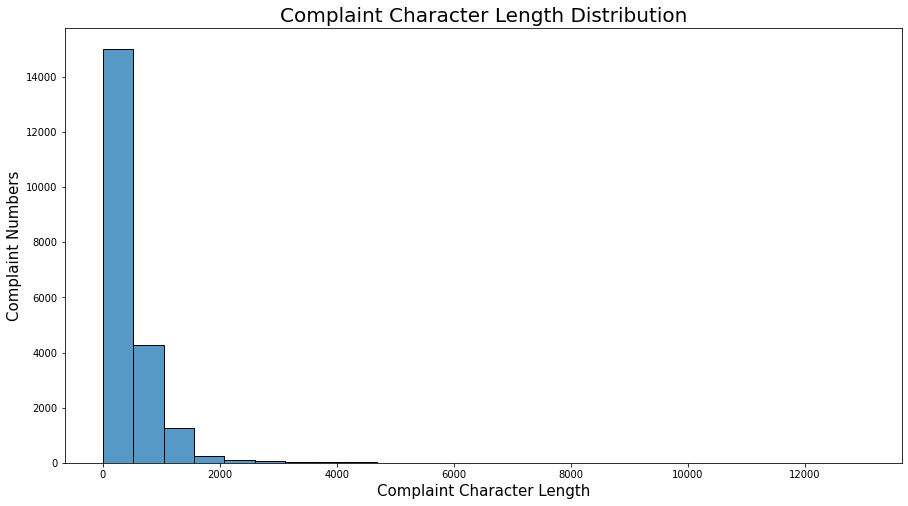

In [51]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=[15,8])
sns.histplot(data = charcter_len,bins=25)
plt.title('Complaint Character Length Distribution', fontsize=20)
plt.xlabel('Complaint Character Length',size=15)
plt.ylabel('Complaint Numbers',size=15)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [52]:
from wordcloud import WordCloud, STOPWORDS

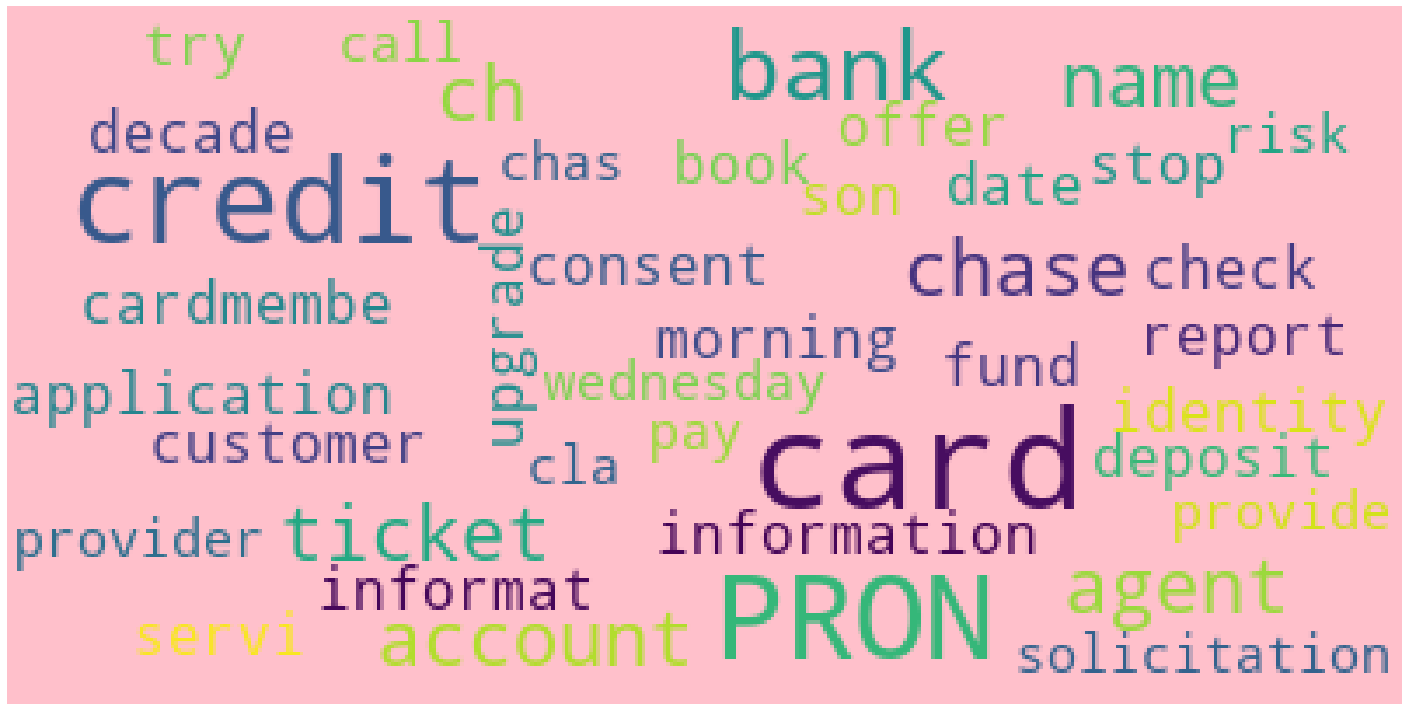

In [53]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='pink',
                          stopwords=stop_words,
                          max_font_size=40,
                          max_words=40, 
                          random_state=40
                         ).generate(str(df_clean['POS_complaint_singular']))

fig = plt.figure(figsize=(25,20))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [54]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['POS_complaint_singular'].str.replace('-PRON-', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [55]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top30_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [56]:
#Print the top 10 words in the unigram frequency
top_30_words = get_top30_unigram(df_clean['Complaint_clean'].values.astype('U'))
df_unigram = pd.DataFrame(top_30_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,50346
1,account,47232
2,credit,34316
3,card,29118
4,bank,28532
5,payment,21361
6,time,16304
7,charge,15712
8,day,13331
9,check,12260


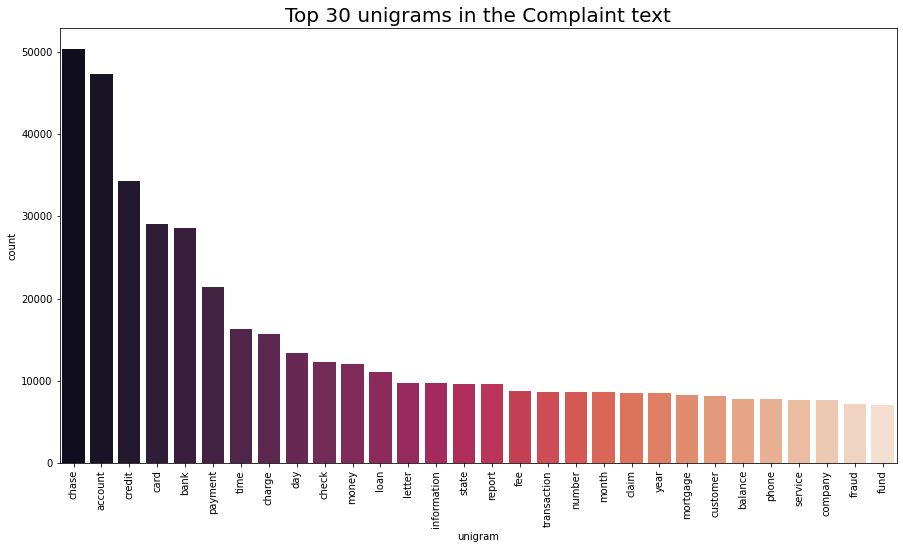

In [57]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
plt.figure(figsize=(15,8))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="rocket")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text", fontsize=20)
plt.show()

In [58]:
#Print the top 10 words in the bigram frequency

In [59]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 


In [60]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [61]:
#It has already been removed earlier
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [62]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemma_complaints,POS_complaint_singular,Complaint_clean
0,good morning my name is and i appreciate it if...,good morning -PRON- name be and i appreciate -...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...
1,i upgraded my card in and was told by the agen...,i upgrade -PRON- card in and be tell by the ag...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...
3,on while trying to book a ticket i came across...,on while try to book a ticket i come across an...,try book ticket i offer ticket card i informat...,try book ticket i offer ticket card i informat...
4,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
21068,on wednesday i called chas my visa credit card...,on wednesday i call chas -PRON- visa credit ca...,wednesday i call chas credit card provider cla...,wednesday i call chas credit card provider cla...
21069,i am not familiar with pay and did not underst...,i be not familiar with pay and do not understa...,pay risk provide consumer i -PRON- bank app ch...,pay risk provide consumer i bank app chase ye...
21070,i have had flawless credit for yrs i ve had ch...,i have have flawless credit for yrs i ve have ...,credit yrs i credit card chase freedom problem...,credit yrs i credit card chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [63]:
#Write your code here to initialise the TfidfVectorizer 

TfidfVectorizer=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [64]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix=TfidfVectorizer.fit_transform(df_clean['POS_complaint_singular'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [65]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [66]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)  #write your code here

In [67]:
nmf_model.fit(doc_term_matrix)
len(TfidfVectorizer.get_feature_names())

7009

In [68]:
topic_single = nmf_model.components_[0]
topic_single.argsort()
top_word_index = topic_single.argsort()[-10:]
for index in top_word_index:
    print(TfidfVectorizer.get_feature_names()[index])

day
branch
deposit
chase
fund
money
pron
check
bank
account


In [69]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([TfidfVectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'pron', 'check', 'bank', 'account']


TOP 15 WORDS FOR TOPIC #1
['year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'pron', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['foreclosure', 'sale', 'house', 'document', 'rate', 'time', 'letter', 'property', 'year', 'modification', 'chase', 'home', 'pron', 'mortgage', 'loan']


TOP 15 WORDS FOR TOPIC #3
['statement', 'time', 'refund', 'service', 'fraud', 'claim', 'purchase', 'merchant', 'transaction', 'dispute', 'chase', 'fee', 'pron', 'card', 'charge']


TOP 15 WORDS FOR TOPIC #4
['mortgage', 'error', 'chase', 'account', 'credit', 'date', 'time', 'day', 'auto', 'pay', 'fee', 'statement', 'month', 'balance', 'payment']




In [70]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(doc_term_matrix)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([2, 1, 1, ..., 3, 4, 4])

In [71]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1)#write your code to assign topics to each rows.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
df_clean.head()

,complaint_what_happened,lemma_complaints,POS_complaint_singular,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning -PRON- name be and i appreciate -...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,2
1,i upgraded my card in and was told by the agen...,i upgrade -PRON- card in and be tell by the ag...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a ticket i came across...,on while try to book a ticket i come across an...,try book ticket i offer ticket card i informat...,try book ticket i offer ticket card i informat...,1
4,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0


In [73]:
#Print the first 5 Complaint for each of the Topics
df_clean_top5=df_clean.groupby('Topic').head(5)
df_clean_top5.sort_values('Topic')

,complaint_what_happened,lemma_complaints,POS_complaint_singular,Complaint_clean,Topic
4,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0
6,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restrict -PRO...,j p restrict account debit card tuesday thursd...,j p restrict account debit card tuesday thursd...,0
10,mishandling of this account by chase auto and,mishandle of this account by chase auto and,mishandle account auto,mishandle account auto,0
12,i opened an account with chase bank on and use...,i open an account with chase bank on and use a...,i account bank code bonus i term everything ac...,i account bank code bonus i term everything ac...,0
15,i opened the saving account for the bonus i wa...,i open the saving account for the bonus i be s...,i account bonus i bonus auto transfer check no...,i account bonus i bonus auto transfer check no...,0
1,i upgraded my card in and was told by the agen...,i upgrade -PRON- card in and be tell by the ag...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a ticket i came across...,on while try to book a ticket i come across an...,try book ticket i offer ticket card i informat...,try book ticket i offer ticket card i informat...,1
5,can you please remove inquiry,can -PRON- please remove inquiry,inquiry,inquiry,1
9,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [74]:
#df_clean.drop(['Topic'], inplace=True, axis=1)

In [75]:
#Create the dictionary of Topic names and Topics

df_clean.replace({'Topic':{0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}},inplace=True)
#Replace Topics with Topic Names
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [76]:
df_clean

,complaint_what_happened,lemma_complaints,POS_complaint_singular,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning -PRON- name be and i appreciate -...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,Others
1,i upgraded my card in and was told by the agen...,i upgrade -PRON- card in and be tell by the ag...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,Credit card or prepaid card
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
3,on while trying to book a ticket i came across...,on while try to book a ticket i come across an...,try book ticket i offer ticket card i informat...,try book ticket i offer ticket card i informat...,Credit card or prepaid card
4,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,Bank Account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
21068,on wednesday i called chas my visa credit card...,on wednesday i call chas -PRON- visa credit ca...,wednesday i call chas credit card provider cla...,wednesday i call chas credit card provider cla...,Theft/Dispute Reporting
21069,i am not familiar with pay and did not underst...,i be not familiar with pay and do not understa...,pay risk provide consumer i -PRON- bank app ch...,pay risk provide consumer i bank app chase ye...,Theft/Dispute Reporting
21070,i have had flawless credit for yrs i ve had ch...,i have have flawless credit for yrs i ve have ...,credit yrs i credit card chase freedom problem...,credit yrs i credit card chase freedom problem...,Mortgage/Loan


In [77]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [78]:
#Create the dictionary again of Topic names and Topics

df_clean.replace({'Topic':{"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}},inplace=True)

df_clean.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_what_happened,lemma_complaints,POS_complaint_singular,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning -PRON- name be and i appreciate -...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,2
1,i upgraded my card in and was told by the agen...,i upgrade -PRON- card in and be tell by the ag...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a ticket i came across...,on while try to book a ticket i come across an...,try book ticket i offer ticket card i informat...,try book ticket i offer ticket card i informat...,1
4,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0


In [79]:
df_clean.shape

(21072, 5)

In [80]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [81]:
training_data.shape

(21072, 2)

In [82]:
training_data.head()

,complaint_what_happened,Topic
0,good morning my name is and i appreciate it if...,2
1,i upgraded my card in and was told by the agen...,1
2,chase card was reported on however fraudulent ...,1
3,on while trying to book a ticket i came across...,1
4,my grand son give me check for i deposit it in...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [83]:

#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

In [84]:
!pip install dill

In [85]:
import dill as pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [86]:
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [87]:
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [88]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [89]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 27428)
y_train Shape: (15804,)
X_test Shape: (5268, 27428)
y_test Shape: (5268,)


In [90]:
def model_evaluation(y_test, y_pred, model_name):
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## Model:1 - Logistic Regression

In [91]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression




In [92]:
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [93]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solv

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [94]:
lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [95]:
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9396024435028837

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.94      0.96      0.95      1308
Credit card or prepaid card       0.95      0.94      0.95      1225
                     Others       0.93      0.93      0.93       967
    Theft/Dispute Reporting       0.93      0.92      0.93      1239
              Mortgage/Loan       0.95      0.93      0.94       529

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



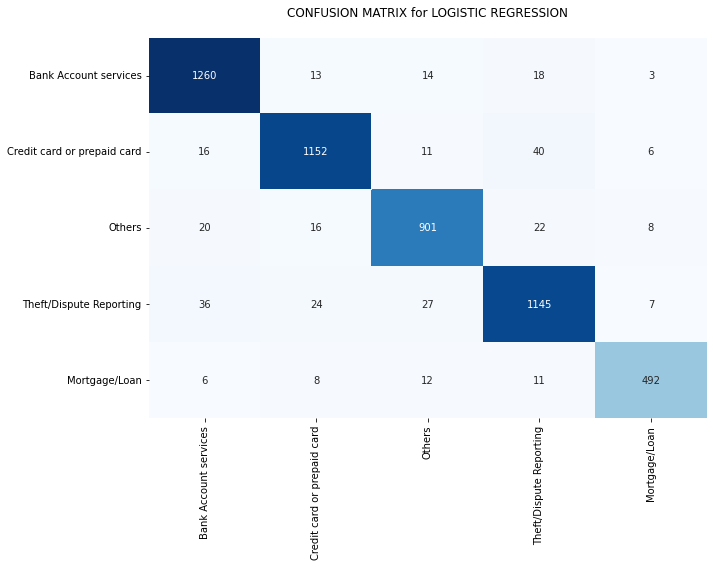

In [96]:
model_evaluation(y_test, y_pred_lr_tuned, model_name)

In [97]:
f1_summary_table = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score': round(f1_lr, 2)}])
f1_summary_table

,Model,F1 Score
0,Logistic Regression,0.94


## Model:2 - Decision Tree

In [98]:
from sklearn.tree import DecisionTreeClassifier

In [99]:
model_name = 'Decision Tree'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [100]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 15}


In [101]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=10, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [102]:
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.8012520055868531

CLASSIFICATION REPORT for Decision Tree

                             precision    recall  f1-score   support

      Bank Account services       0.80      0.85      0.82      1308
Credit card or prepaid card       0.85      0.82      0.83      1225
                     Others       0.80      0.82      0.81       967
    Theft/Dispute Reporting       0.75      0.74      0.74      1239
              Mortgage/Loan       0.83      0.76      0.79       529

                   accuracy                           0.80      5268
                  macro avg       0.81      0.80      0.80      5268
               weighted avg       0.80      0.80      0.80      5268



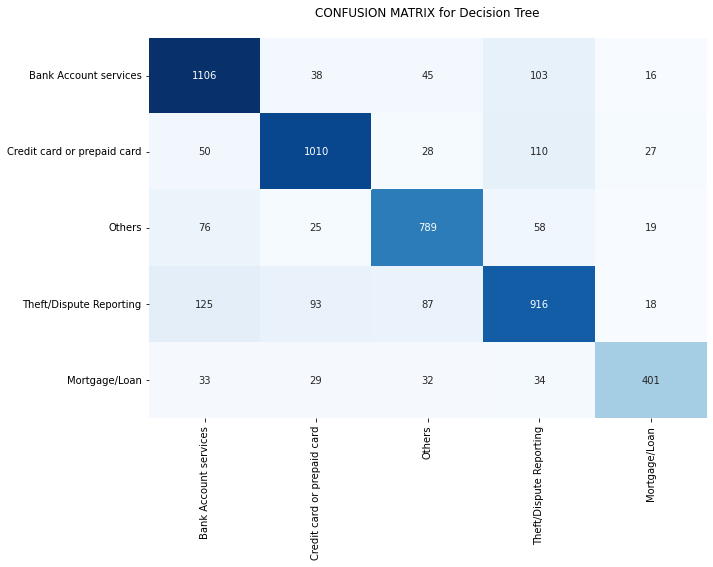

In [103]:
model_evaluation(y_test, y_pred_dt_tuned, model_name)

In [104]:
f1_summary_table.loc[len(f1_summary_table.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary_table

,Model,F1 Score
0,Logistic Regression,0.94
1,Decision Tree,0.80


In [105]:
# Save Logistic Regression model as pickle file in device
pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))

## Model:3 - Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier

In [107]:
model_name = 'Random Forest'
rf_cfl = RandomForestClassifier(n_estimators = 200, 
                                 max_features = 'auto', 
                                 min_samples_leaf = 5, 
                                 min_samples_split = 6, 
                                 n_jobs = -1,
                                random_state = 42)

rf_cfl.fit(X_train, y_train)
y_pred_rf = rf_cfl.predict(X_test)

In [108]:
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.7942909237739021

CLASSIFICATION REPORT for Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.92      0.85      1308
Credit card or prepaid card       0.80      0.84      0.82      1225
                     Others       0.85      0.84      0.85       967
    Theft/Dispute Reporting       0.78      0.83      0.80      1239
              Mortgage/Loan       0.96      0.32      0.48       529

                   accuracy                           0.81      5268
                  macro avg       0.83      0.75      0.76      5268
               weighted avg       0.82      0.81      0.79      5268



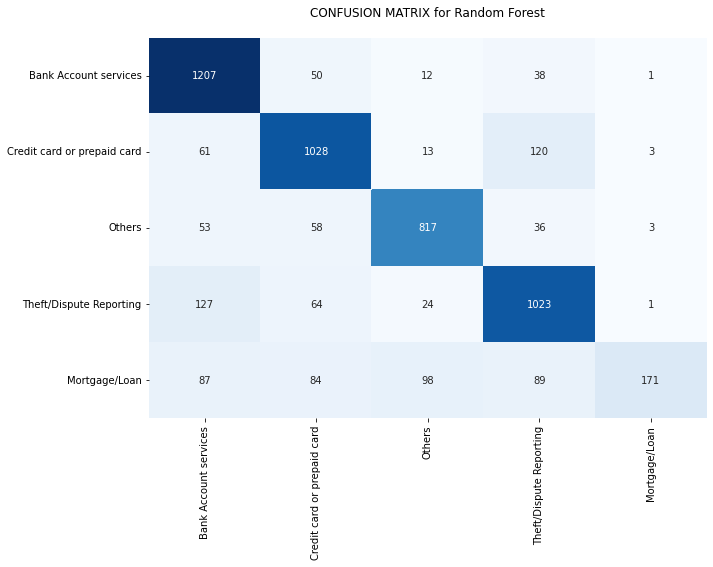

In [109]:
model_evaluation(y_test, y_pred_rf, model_name)

In [110]:
f1_summary_table.loc[len(f1_summary_table.index)] = ['Random Forest', round(f1_rf, 2)]
f1_summary_table

,Model,F1 Score
0,Logistic Regression,0.94
1,Decision Tree,0.80
2,Random Forest,0.79


## Model:4 - Naive Bayes

In [111]:
from sklearn.naive_bayes import MultinomialNB

In [112]:
model_name = 'Naive Bayes'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [113]:
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [114]:
model_name = 'Naive Bayes'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [115]:
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

0.7807940044392372

CLASSIFICATION REPORT for Naive Bayes

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.81      1308
Credit card or prepaid card       0.80      0.75      0.77      1225
                     Others       0.83      0.83      0.83       967
    Theft/Dispute Reporting       0.77      0.78      0.77      1239
              Mortgage/Loan       0.68      0.65      0.66       529

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



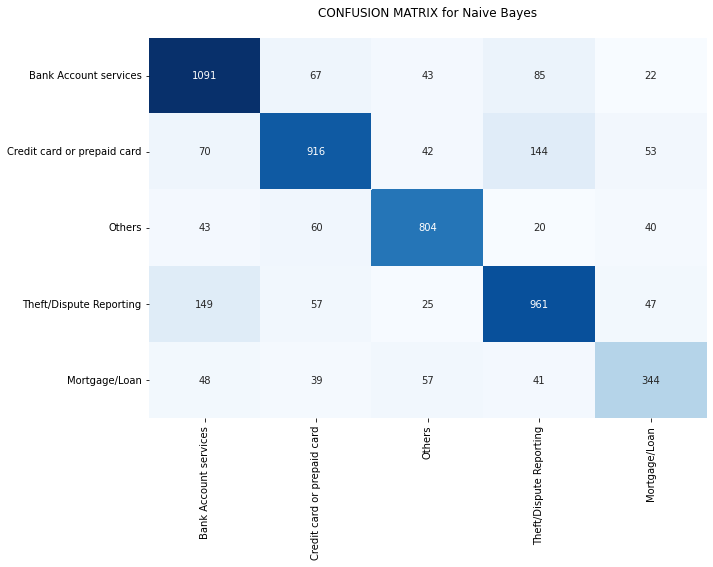

In [116]:
model_evaluation(y_test, y_pred_nb_tuned, model_name)

In [117]:
f1_summary_table.loc[len(f1_summary_table.index)] = ['Naive Bayes', round(f1_nb, 2)]
f1_summary_table

,Model,F1 Score
0,Logistic Regression,0.94
1,Decision Tree,0.80
2,Random Forest,0.79
3,Naive Bayes,0.78


### As per our observation after assesing all  the four models, Logistic Regression performs best. Hence we'll check the performance of the model through custome text 

In [118]:
def topic_predicter(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [119]:
df_custom = pd.DataFrame({'complaints': ["How I can take a Loan through mortaging my assets ?", 
                                  "Would you please share me Branch info in Gulshan ?",
                                  "In my last statement, I have observed some disputes in the Bill. Please let me know how I can resolve the issue.",
                                  "While doing transaction in latest payment, money has been deducted twice. Please take the necessary precaution",
                                  "I want to change my credit card bill date. Please let me know the process"       
                                  ]})
df_custom

,complaints
0,How I can take a Loan through mortaging my ass...
1,Would you please share me Branch info in Gulsh...
2,"In my last statement, I have observed some dis..."
3,"While doing transaction in latest payment, mon..."
4,I want to change my credit card bill date. Ple...


In [120]:
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predicter([x]))
df_custom

,complaints,predicted topic
0,How I can take a Loan through mortaging my ass...,Others
1,Would you please share me Branch info in Gulsh...,Bank Account services
2,"In my last statement, I have observed some dis...",Theft/Dispute Reporting
3,"While doing transaction in latest payment, mon...",Mortgage/Loan
4,I want to change my credit card bill date. Ple...,Credit card or prepaid card
